In [35]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
import os
os.listdir('./data')

['model.png', 'model.png.pdf', 'train(add_split_factor).csv', 'train.csv']

In [36]:
def get_group_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

In [37]:
df = pd.read_csv('./data/train(add_split_factor).csv',index_col=0)
print(df.shape)
df.head()

(14023, 436)


,Case Conditions_Feed Rate to C013 (Input),Case Conditions_C7+ in Light End (Input),Case Conditions_Heart Cut Prod. Rate (Input),Case Conditions_C6P- in Heart Cut (Input),Case Conditions_Feed Rate to C013 (Results),Case Conditions_C7+ in Light End (Results),Case Conditions_Heart Cut Prod. Rate (Results),Case Conditions_C6P- in Heart Cut (Results),Case Conditions_C10+ in Heart Cut (Results),Naphtha Properties_Naphtha Feed Rate,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane",Individual Component to Heavy End Split Factor_3-Methylnonane,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane,Individual Component to Heavy End Split Factor_n-Decane,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene",Individual Component to Heavy End Split Factor_n-Undecane,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Tridecane
0,10.0,2.5,100.0,1.0,10.000001,2.500057,100.000198,1.000427,6.138641,118.000084,...,0.348342,0.378793,0.381912,0.397334,0.409138,0.433925,0.440811,0.451332,0.454764,1.0
1,10.0,5.0,100.0,1.0,10.000001,4.999882,100.000122,1.000401,6.249050,118.000000,...,0.336983,0.367462,0.370631,0.386031,0.397878,0.422758,0.429677,0.440263,0.443717,1.0
2,10.0,10.0,100.0,1.0,10.000001,10.000006,100.000008,0.999993,6.376052,118.000000,...,0.323372,0.354403,0.357728,0.373260,0.385311,0.410579,0.417606,0.428374,0.431884,1.0
3,10.0,2.5,100.0,1.5,10.000001,2.500020,100.000275,1.500293,6.316332,118.000000,...,0.334064,0.360351,0.362654,0.376680,0.387033,0.409416,0.415640,0.425230,0.428354,1.0
4,10.0,5.0,100.0,1.5,10.000001,5.000001,99.999817,1.499961,6.416863,118.000084,...,0.323809,0.350009,0.352356,0.366307,0.376672,0.399048,0.405285,0.414893,0.418027,1.0


# defiine columns

In [38]:
case_col = df.columns[(df.columns.str.contains('Case'))&(df.columns.str.contains('Input'))].tolist()
case_col

['Case Conditions_Feed Rate to C013 (Input)',
 'Case Conditions_C7+ in Light End (Input)',
 'Case Conditions_Heart Cut Prod. Rate (Input)',
 'Case Conditions_C6P- in Heart Cut (Input)']

In [39]:
naphtha_col = df.columns[df.columns.str.contains('Naphtha Properties')].tolist()[5:-1]
print(len(naphtha_col))
naphtha_col[0],naphtha_col[-1]

54


('Naphtha Properties_Oxygen', 'Naphtha Properties_n-Tridecane')

In [40]:
s_col = get_group_col(df,'Individual Component')
print(len(s_col))

162


# sort s_col

In [41]:
df.columns

Index(['Case Conditions_Feed Rate to C013 (Input)',
       'Case Conditions_C7+ in Light End (Input)',
       'Case Conditions_Heart Cut Prod. Rate (Input)',
       'Case Conditions_C6P- in Heart Cut (Input)',
       'Case Conditions_Feed Rate to C013 (Results)',
       'Case Conditions_C7+ in Light End (Results)',
       'Case Conditions_Heart Cut Prod. Rate (Results)',
       'Case Conditions_C6P- in Heart Cut (Results)',
       'Case Conditions_C10+ in Heart Cut (Results)',
       'Naphtha Properties_Naphtha Feed Rate',
       ...
       'Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane',
       'Individual Component to Heavy End Split Factor_3-Methylnonane',
       'Individual Component to Heavy End Split Factor_tert-Butylcyclohexane',
       'Individual Component to Heavy End Split Factor_n-Decane',
       'Individual Component to Heavy End Split Factor_1,2-Diethylbenzene',
       'Individual Component to Heavy End Split Factor_n-Undecane',
       'Individu

In [42]:
temp = []
for i in [i.split('_')[1] for i in naphtha_col]:
    col1 = 'Individual Component to Light End Split Factor_{}'.format(i)
    col2 = 'Individual Component to Heart Cut Split Factor_{}'.format(i)
    col3 = 'Individual Component to Heavy End Split Factor_{}'.format(i)
    cols = [col1,col2,col3]
    temp += cols
s_col = temp
print(len(s_col))

162


In [43]:
for _ in range(1):
    idx = np.random.randint(0,163)
    fig = px.scatter_3d(df.sample(1000), 
                        x = case_col[1], 
                        y = case_col[2], 
                        z = case_col[3],
                        color = s_col[idx])
    fig.show()

# scale

In [44]:
x_col = case_col + naphtha_col
y_col = s_col

In [45]:
print(len(x_col))
print(len(y_col))

58
162


In [46]:
ss = StandardScaler().fit(df[x_col])
df[x_col] = ss.transform(df[x_col])

# split train test

In [47]:
X = df[x_col]
Y = df[y_col]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(12620, 58)
(1403, 58)
(12620, 162)
(1403, 162)


# tensor

In [48]:
X_train = torch.tensor(X_train.values, dtype=torch.float).cuda()
X_test = torch.tensor(X_test.values, dtype=torch.float).cuda()
Y_train = torch.tensor(Y_train.values, dtype=torch.float).cuda()
Y_test = torch.tensor(Y_test.values, dtype=torch.float).cuda()

# data_iter

In [49]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [54]:
class Dual_net(nn.Module):
    def __init__(self):
        super(Dual_net,self).__init__()
        self.C_net = self._build_C_net(4,1)
        self.N_net = self._build_N_net(54,54) 
        self.F_net = self._build_F_net(55,55)
        # build O_net
        self.O_net1 = self._build_O_net(55,3)
        self.O_net2 = self._build_O_net(55,3)
        self.O_net3 = self._build_O_net(55,3)
        self.O_net4 = self._build_O_net(55,3)
        self.O_net5 = self._build_O_net(55,3)
        self.O_net6 = self._build_O_net(55,3)
        self.O_net7 = self._build_O_net(55,3)
        self.O_net8 = self._build_O_net(55,3)
        self.O_net9 = self._build_O_net(55,3)
        self.O_net10 = self._build_O_net(55,3)
        self.O_net11 = self._build_O_net(55,3)
        self.O_net12 = self._build_O_net(55,3)
        self.O_net13 = self._build_O_net(55,3)
        self.O_net14 = self._build_O_net(55,3)
        self.O_net15 = self._build_O_net(55,3)
        self.O_net16 = self._build_O_net(55,3)
        self.O_net17 = self._build_O_net(55,3)
        self.O_net18 = self._build_O_net(55,3)
        self.O_net19 = self._build_O_net(55,3)
        self.O_net20 = self._build_O_net(55,3)
        self.O_net21 = self._build_O_net(55,3)
        self.O_net22 = self._build_O_net(55,3)
        self.O_net23 = self._build_O_net(55,3)
        self.O_net24 = self._build_O_net(55,3)
        self.O_net25 = self._build_O_net(55,3)
        self.O_net26 = self._build_O_net(55,3)
        self.O_net27 = self._build_O_net(55,3)
        self.O_net28 = self._build_O_net(55,3)
        self.O_net29 = self._build_O_net(55,3)
        self.O_net30 = self._build_O_net(55,3)
        self.O_net31 = self._build_O_net(55,3)
        self.O_net32 = self._build_O_net(55,3)
        self.O_net33 = self._build_O_net(55,3)
        self.O_net34 = self._build_O_net(55,3)
        self.O_net35 = self._build_O_net(55,3)
        self.O_net36 = self._build_O_net(55,3)
        self.O_net37 = self._build_O_net(55,3)
        self.O_net38 = self._build_O_net(55,3)
        self.O_net39 = self._build_O_net(55,3)
        self.O_net40 = self._build_O_net(55,3)
        self.O_net41 = self._build_O_net(55,3)
        self.O_net42 = self._build_O_net(55,3)
        self.O_net43 = self._build_O_net(55,3)
        self.O_net44 = self._build_O_net(55,3)
        self.O_net45 = self._build_O_net(55,3)
        self.O_net46 = self._build_O_net(55,3)
        self.O_net47 = self._build_O_net(55,3)
        self.O_net48 = self._build_O_net(55,3)
        self.O_net49 = self._build_O_net(55,3)
        self.O_net50 = self._build_O_net(55,3)
        self.O_net51 = self._build_O_net(55,3)
        self.O_net52 = self._build_O_net(55,3)
        self.O_net53 = self._build_O_net(55,3)
        self.O_net54 = self._build_O_net(55,3)
        # O_nets list
        self.O_nets = [self.O_net1,self.O_net2,self.O_net3,self.O_net4,self.O_net5,
                       self.O_net6,self.O_net7,self.O_net8,self.O_net9,self.O_net10,
                       self.O_net11,self.O_net12,self.O_net13,self.O_net14,self.O_net15,
                       self.O_net16,self.O_net17,self.O_net18,self.O_net19,self.O_net20,
                       self.O_net21,self.O_net22,self.O_net23,self.O_net24,self.O_net25,
                       self.O_net26,self.O_net27,self.O_net28,self.O_net29,self.O_net30,
                       self.O_net31,self.O_net32,self.O_net33,self.O_net34,self.O_net35,
                       self.O_net36,self.O_net37,self.O_net38,self.O_net39,self.O_net40,
                       self.O_net41,self.O_net42,self.O_net43,self.O_net44,self.O_net45,
                       self.O_net46,self.O_net47,self.O_net48,self.O_net49,self.O_net50,
                       self.O_net51,self.O_net52,self.O_net53,self.O_net54]
            
    def forward(self,x):
        c,n = self._Fetch(x)
        c,n = self.C_net(c),self.N_net(n)
        f = torch.cat((c,n),dim=1)
        f = self.F_net(f)
        output = torch.tensor([]).cuda()
        for i in self.O_nets:
            v = F.softmax(i(f),dim=1)
            output = torch.cat((output,v),dim=1)
        return output
    
    @staticmethod
    def _Fetch(x):
        return x[:,:4],x[:,4:]
    
    @staticmethod
    def _build_C_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_N_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_F_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_O_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),ReLU(),
            Linear(128,output_shape))
        return net.cuda()

In [55]:
# initialize weight and bias
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [56]:
net = Dual_net().cuda()
net.apply(init_weights)

Dual_net(
  (C_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (N_net): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=54, bias=True)
  )
  (F_net): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=55, bias=True)
  )
  (O_net1): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (O_net2): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (O_net3): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  

# forward test

In [57]:
y = net(X_test)
print(y.shape)
y[0]

torch.Size([1403, 162])


tensor([0.1496, 0.5695, 0.2809, 0.3219, 0.2591, 0.4190, 0.4235, 0.2528, 0.3237,
        0.4624, 0.2394, 0.2982, 0.2997, 0.3967, 0.3036, 0.2596, 0.6132, 0.1272,
        0.6095, 0.2527, 0.1379, 0.1550, 0.1946, 0.6504, 0.1329, 0.1756, 0.6916,
        0.3311, 0.4868, 0.1821, 0.1582, 0.4571, 0.3847, 0.5143, 0.2856, 0.2001,
        0.2097, 0.3384, 0.4519, 0.2678, 0.3318, 0.4004, 0.3283, 0.3460, 0.3256,
        0.3241, 0.4708, 0.2051, 0.2333, 0.5155, 0.2513, 0.1180, 0.5562, 0.3258,
        0.6105, 0.1985, 0.1911, 0.1039, 0.3462, 0.5499, 0.3221, 0.2049, 0.4730,
        0.2211, 0.4856, 0.2933, 0.3051, 0.2104, 0.4845, 0.2925, 0.3943, 0.3132,
        0.1826, 0.3285, 0.4888, 0.4859, 0.1399, 0.3742, 0.4437, 0.2691, 0.2872,
        0.3595, 0.2492, 0.3913, 0.6138, 0.1524, 0.2338, 0.2302, 0.3533, 0.4165,
        0.1563, 0.1533, 0.6904, 0.4343, 0.3434, 0.2223, 0.1982, 0.3061, 0.4957,
        0.4990, 0.2270, 0.2741, 0.3473, 0.1935, 0.4592, 0.4264, 0.2951, 0.2785,
        0.1729, 0.3547, 0.4725, 0.2636, 

# torchviz

In [58]:
#y = net(X_test)
#dot = torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))
#dot
#dot.render("./data/model.png")

# tensorboard

In [59]:
#with SummaryWriter(comment='Net')as w:
#    w.add_graph(net, (X_test,))

# loss_function and optimizer

In [60]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# Training and evaluation

In [61]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    history = []
    for epoch in range(num_epochs):
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    
        # end for
        history.append(loss.item())
        print("epochs {} loss {:.4f}".format(epoch,loss.item()))
    # end for
    plt.plot(np.array(history))
    plt.title('train loss')
    return net

epochs 0 loss 0.0042
epochs 1 loss 0.0027
epochs 2 loss 0.0020
epochs 3 loss 0.0019
epochs 4 loss 0.0018
epochs 5 loss 0.0023
epochs 6 loss 0.0013
epochs 7 loss 0.0014
epochs 8 loss 0.0018
epochs 9 loss 0.0014
epochs 10 loss 0.0013
epochs 11 loss 0.0014
epochs 12 loss 0.0016
epochs 13 loss 0.0016
epochs 14 loss 0.0014
epochs 15 loss 0.0011
epochs 16 loss 0.0013
epochs 17 loss 0.0011
epochs 18 loss 0.0017
epochs 19 loss 0.0016


Dual_net(
  (C_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (N_net): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=54, bias=True)
  )
  (F_net): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=55, bias=True)
  )
  (O_net1): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (O_net2): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (O_net3): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  

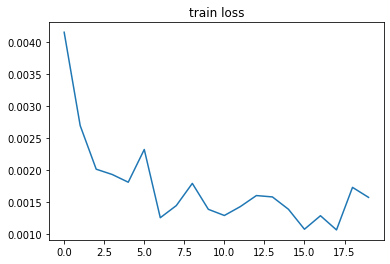

In [62]:
train(net,train_iter,loss_function,optimizer,num_epochs=20)

# make predict

In [63]:
y_pred = net(X_test).cpu().detach().numpy()
y_real = Y_test.cpu().detach().numpy()
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_real = pd.DataFrame(y_real,columns=y_col)

In [64]:
y_pred.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Heart Cut Split Factor_Oxygen,Individual Component to Heavy End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Heart Cut Split Factor_Methane,Individual Component to Heavy End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Heart Cut Split Factor_Ethane,Individual Component to Heavy End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,...,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Light End Split Factor_n-Dodecane,Individual Component to Heart Cut Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Light End Split Factor_n-Hexylbenzene,Individual Component to Heart Cut Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Light End Split Factor_n-Tridecane,Individual Component to Heart Cut Split Factor_n-Tridecane,Individual Component to Heavy End Split Factor_n-Tridecane
0,0.999946,0.000009,0.000045,0.999981,0.000010,0.000009,0.999879,0.000034,0.000087,0.999001,...,0.563946,0.000978,0.450397,0.548625,0.000340,0.430248,0.569412,0.000047,0.000126,0.999827
1,0.999974,0.000005,0.000021,0.999981,0.000009,0.000009,0.999971,0.000014,0.000015,0.999679,...,0.511513,0.001046,0.487556,0.511398,0.000065,0.475041,0.524894,0.000010,0.000031,0.999959
2,0.998876,0.000389,0.000735,0.998634,0.000870,0.000496,0.998675,0.000692,0.000633,0.993092,...,0.480090,0.007738,0.507596,0.484666,0.001858,0.513019,0.485124,0.000371,0.001195,0.998434
3,0.998724,0.000457,0.000819,0.998245,0.001001,0.000754,0.999133,0.000462,0.000405,0.993233,...,0.477860,0.007230,0.513608,0.479161,0.001170,0.510875,0.487956,0.000364,0.001028,0.998608
4,0.999729,0.000072,0.000198,0.999603,0.000247,0.000149,0.999648,0.000163,0.000188,0.996545,...,0.500665,0.004417,0.482836,0.512747,0.000673,0.483241,0.516086,0.000119,0.000464,0.999418


In [65]:
y_real.head()

,Individual Component to Light End Split Factor_Oxygen,Individual Component to Heart Cut Split Factor_Oxygen,Individual Component to Heavy End Split Factor_Oxygen,Individual Component to Light End Split Factor_Methane,Individual Component to Heart Cut Split Factor_Methane,Individual Component to Heavy End Split Factor_Methane,Individual Component to Light End Split Factor_Ethane,Individual Component to Heart Cut Split Factor_Ethane,Individual Component to Heavy End Split Factor_Ethane,Individual Component to Light End Split Factor_Propane,...,Individual Component to Heavy End Split Factor_n-Pentylbenzene,Individual Component to Light End Split Factor_n-Dodecane,Individual Component to Heart Cut Split Factor_n-Dodecane,Individual Component to Heavy End Split Factor_n-Dodecane,Individual Component to Light End Split Factor_n-Hexylbenzene,Individual Component to Heart Cut Split Factor_n-Hexylbenzene,Individual Component to Heavy End Split Factor_n-Hexylbenzene,Individual Component to Light End Split Factor_n-Tridecane,Individual Component to Heart Cut Split Factor_n-Tridecane,Individual Component to Heavy End Split Factor_n-Tridecane
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.990195,...,0.541440,0.0,0.444430,0.555570,0.0,0.438134,0.561866,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.989926,...,0.446123,0.0,0.542868,0.457133,0.0,0.539033,0.460967,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.995476,...,0.471574,0.0,0.520133,0.479867,0.0,0.516367,0.483633,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.995519,...,0.444630,0.0,0.547191,0.452809,0.0,0.543118,0.456882,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.989136,...,0.512464,0.0,0.478286,0.521715,0.0,0.473906,0.526094,0.0,0.0,1.0


# metric

In [66]:
res = pd.DataFrame(index=y_col,columns=['R2','RMSE'])
for i in y_col:
  res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
  res.loc[i,'RMSE'] = sqrt(mean_squared_error(y_real[i],y_pred[i]))
res.loc['AVG'] = res.mean(axis=0)
res

,R2,RMSE
Individual Component to Light End Split Factor_Oxygen,0,0.00192986
Individual Component to Heart Cut Split Factor_Oxygen,0,0.000645375
Individual Component to Heavy End Split Factor_Oxygen,0,0.00128939
Individual Component to Light End Split Factor_Methane,0,0.00208085
Individual Component to Heart Cut Split Factor_Methane,0,0.00123531
...,...,...
Individual Component to Heavy End Split Factor_n-Hexylbenzene,0.400534,0.0554264
Individual Component to Light End Split Factor_n-Tridecane,0,0.000813885
Individual Component to Heart Cut Split Factor_n-Tridecane,0,0.00171855
Individual Component to Heavy End Split Factor_n-Tridecane,0,0.00252791
